In [11]:
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from scipy import signal
from scipy.stats import pearsonr
from scipy.optimize import curve_fit

In [12]:
def flatter(data, polynomialOrder=15):

    ## Применяем медианную фильтрацию с максимальным шагом:
    res_filter = data # signal.medfilt(data, kernel_size=29)
    # Фитируем получившийся массив:
    xData = range(len(res_filter))
    yData = res_filter
    # curve fit the data
    fittedParameters = np.polyfit(xData, yData, polynomialOrder)
    xModel = np.linspace(min(xData), max(xData), len(xData))
    yModel = np.polyval(fittedParameters, xModel)

    return yModel

In [13]:
def fake_pulse(pulse, amp):
    return_pulse = []
    for i in pulse:
        if i != 0:
            return_pulse.append(i+ np.random.uniform(-amp, amp))
        else:
            return_pulse.append(0)
    return return_pulse

In [37]:
gp_table = pd.read_table('typized_dataset_for_dina.csv', sep='\t')
pattern = np.genfromtxt('total_profile.txt')

T_SCATTERING = 15.85

In [45]:
noises = gp_table[gp_table.type == 0]
pulses = gp_table[gp_table.type == 1]

In [39]:
def new_pulse(pulse):
    amp_pls = np.std(pulse[:20])/3
    return (pulse
            + np.random.normal(loc=0.0, scale=amp_pls, size=len(pulse))
            - np.random.normal(loc=0.0, scale=amp_pls, size=len(pulse)))


def screan(t, t_s):
    if t < 0:
        return 0
    else:
        return np.exp(-t/t_s)


def gauss(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

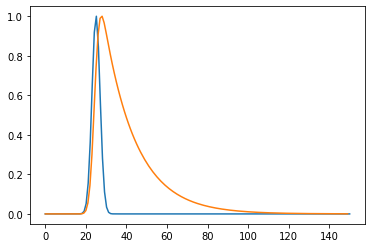

In [40]:
x = np.linspace(0, 150, 150)
gs = gauss(x, 0.1, 25, 2)
scr = [screan(i, T_SCATTERING) for i in x] 
plt.plot(x, gs/max(gs))
plt.plot(np.convolve(gs, scr,'full')[:150]/max(np.convolve(scr, gs)))
plt.show()

In [41]:
def my_pulse(x,a,x0,sigma, t_s):
    gs = gauss(x, a, x0, sigma)
    scr = [screan(i, t_s) for i in x] 
    return np.convolve(scr, gs, 'full')[:150]

+ Создаем базу для новых импульсов
+ Берется импульс из базы оригинальных
+ Определяется амплитуда шумов импульса в начале записи
+ Импульс фитируется 
+ На фитинг накладывается шум с уже определенной амплитудой (10 раз)
+ Каждый размноженый импульс сохраняется в новую базу.
+ Произвести сравнение основных и сгенерированных импульсов

In [46]:
pulses_mega_pack = pd.DataFrame(columns=pulses.columns)
noises_mega_pack = pd.DataFrame(columns=noises.columns)

In [47]:
full_index = 0
for idx, row in pulses.iterrows():
    x = np.linspace(0, 150, 150)
    y = np.asarray(pulses.loc[idx][:-1])
    
    # выравнивение импульса относительно 0
    y -= np.median(y[:11])
    # Определение амплитуды шума
    ampl_noise = np.std(y[:11])
    
    amp = 1
    mean = 25
    sigma = 3
    t_s = 10
    
    try:
        popt,pcov = curve_fit(my_pulse,x,y,p0=[amp,mean,sigma, t_s])
        new_pulse = my_pulse(x,*popt)

    except RuntimeError:
        continue
    
    for _ in range(10):
        noise = np.random.normal(0, ampl_noise, len(new_pulse))
        new_pulse_to_table = new_pulse + noise
        pulses_mega_pack.loc[full_index] = [*new_pulse_to_table, 1]
        full_index += 1

c:\users\professional\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in exp
  if sys.path[0] == '':


In [48]:
# creating addition dataset for noises
count = 0
for j in noises.index:
    for i in range(10):
        test_pulse = list(noises.loc[j][:-1])
        std_end_pulse = 0.13
        fk_pulse = fake_pulse(test_pulse, std_end_pulse)
        noises_mega_pack.loc[count] = [*fk_pulse, 0]
        count += 1

In [49]:
# For vizualization
real_pulse_start_std = []
real_pulse_end_std = []
real_pulse_full_std = []

fake_pulse_start_std = []
fake_pulse_end_std = []
fake_pulse_full_std = []

real_noise_start_std = []
real_noise_end_std = []
real_noise_full_std = []

fake_noise_start_std = []
fake_noise_end_std = []
fake_noise_full_std = []

for idx, row in enumerate(pulses.iterrows()):
    real_pulse_start_std.append(np.std(row[1][0:20]))
    real_pulse_end_std.append(np.std(row[1][-30:-1]))
    real_pulse_full_std.append(np.std(row[1][:-1]))

for idx, row in enumerate(pulses_mega_pack.iterrows()):
    fake_pulse_start_std.append(np.std(row[1][0:20]))
    fake_pulse_end_std.append(np.std(row[1][-30:-1]))
    fake_pulse_full_std.append(np.std(row[1][:-1]))

for idx, row in enumerate(noises.iterrows()):
    real_noise_start_std.append(np.std(row[1][0:20]))
    real_noise_end_std.append(np.std(row[1][-30:-1]))
    real_noise_full_std.append(np.std(row[1][:-1]))

for idx, row in enumerate(noises_mega_pack.iterrows()):
    fake_noise_start_std.append(np.std(row[1][0:20]))
    fake_noise_end_std.append(np.std(row[1][-30:-1]))
    fake_noise_full_std.append(np.std(row[1][:-1]))

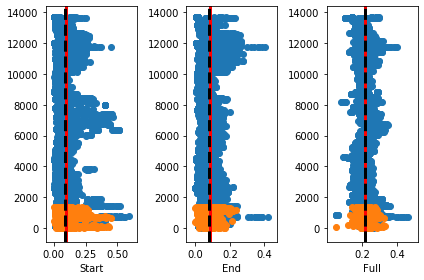

In [55]:
plt.close()
plt.subplot(1, 3, 1)
plt.xlabel('Start')
plt.scatter(fake_pulse_start_std,range(len(fake_pulse_start_std)))
plt.scatter(real_pulse_start_std, range(len(real_pulse_start_std)))
plt.axvline(np.mean(real_pulse_start_std), lw=3, color='r')
plt.axvline(np.mean(fake_pulse_start_std), lw=3, color='black', ls='--')
plt.subplot(1, 3, 2)
plt.xlabel('End')
plt.scatter(fake_pulse_end_std, range(len(fake_pulse_end_std)))
plt.scatter(real_pulse_end_std, range(len(real_pulse_end_std)))
plt.axvline(np.mean(real_pulse_end_std), lw=3, color='r')
plt.axvline(np.mean(fake_pulse_end_std), lw=3, color='black', ls='--')
plt.subplot(1, 3, 3)
plt.xlabel('Full')
plt.scatter(fake_pulse_full_std, range(len(fake_pulse_full_std)))
plt.scatter(real_pulse_full_std, range(len(real_pulse_full_std)))
plt.axvline(np.mean(real_pulse_full_std), lw=3, color='r')
plt.axvline(np.mean(fake_pulse_full_std), lw=3, color='black', ls='--')
plt.tight_layout()
plt.show()

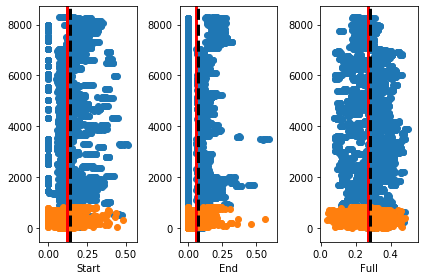

In [56]:
plt.close()
plt.subplot(1, 3, 1)
plt.xlabel('Start')
plt.scatter(fake_noise_start_std,range(len(fake_noise_start_std)))
plt.scatter(real_noise_start_std, range(len(real_noise_start_std)))
plt.axvline(np.mean(real_noise_start_std), lw=3, color='r')
plt.axvline(np.mean(fake_noise_start_std), lw=3, color='black', ls='--')
plt.subplot(1, 3, 2)
plt.xlabel('End')
plt.scatter(fake_noise_end_std, range(len(fake_noise_end_std)))
plt.scatter(real_noise_end_std, range(len(real_noise_end_std)))
plt.axvline(np.mean(real_noise_end_std), lw=3, color='r')
plt.axvline(np.mean(fake_noise_end_std), lw=3, color='black', ls='--')
plt.subplot(1, 3, 3)
plt.xlabel('Full')
plt.scatter(fake_noise_full_std, range(len(fake_noise_full_std)))
plt.scatter(real_noise_full_std, range(len(real_noise_full_std)))
plt.axvline(np.mean(real_noise_full_std), lw=3, color='r')
plt.axvline(np.mean(fake_noise_full_std), lw=3, color='black', ls='--')
plt.tight_layout()
plt.show()

In [157]:
# combine packs together
result_frame = pd.concat([pulses, noises, pulses_mega_pack, noises_mega_pack])

In [158]:
result_frame = result_frame.reset_index(drop=True)

In [159]:
result_frame = result_frame.sample(30100).reset_index(drop=True)

In [160]:
result_frame

,point_0,point_1,point_2,point_3,point_4,point_5,point_6,point_7,point_8,point_9,...,point_141,point_142,point_143,point_144,point_145,point_146,point_147,point_148,point_149,type
0,0.978982,0.600792,0.576295,0.879071,0.748419,0.700882,0.808217,0.756189,0.937267,0.656817,...,-0.170598,-0.040731,0.055434,-0.030381,-0.060119,0.038711,-0.207188,-0.327987,-0.026227,0.0
1,-0.046221,-0.016026,-0.069947,-0.017973,-0.028160,-0.005879,-0.122640,-0.022876,-0.030940,0.005005,...,0.061523,0.025700,0.118280,0.067003,0.090839,-0.069283,-0.008646,0.067241,0.045706,1.0
2,0.027795,0.037606,0.040863,0.135837,0.024407,0.015284,0.004629,-0.028649,-0.050140,0.122780,...,0.024338,-0.025538,0.049220,-0.024554,0.048421,-0.001028,0.128556,0.105247,0.081709,1.0
3,-0.092483,0.024088,0.145415,0.193473,0.088773,0.035256,-0.001771,-0.055982,0.000804,0.064992,...,-0.027176,0.022993,0.010239,-0.031870,0.022775,0.082362,0.054780,0.058370,0.025668,1.0
4,-0.245618,-0.215813,-0.155470,0.132695,0.247526,0.153856,-0.098590,0.013599,0.015258,0.103669,...,0.184631,-0.052737,-0.169983,-0.157704,0.415985,0.178661,0.228058,0.099832,-0.275830,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30095,-0.045956,-0.024024,-0.002831,0.030766,0.016950,0.010178,0.002656,0.021405,-0.026715,-0.003883,...,0.030998,0.107310,0.069951,0.133985,0.092593,0.069622,0.071456,0.031802,0.019237,1.0
30096,-0.046713,-0.079228,-0.011660,0.122095,0.044002,-0.057404,-0.112664,-0.110412,-0.007963,-0.023589,...,0.042004,-0.025379,-0.031888,-0.051869,-0.023643,0.118647,0.107225,0.038447,0.091439,1.0
30097,0.011909,0.028410,-0.027651,0.016606,-0.013588,0.021380,-0.055476,-0.044285,-0.003765,0.012023,...,0.043173,0.038468,0.035248,0.042385,0.028186,0.016542,0.039146,0.056171,0.023695,1.0
30098,0.449334,0.494104,0.414751,0.301929,0.474813,0.378049,0.496939,0.623295,0.415871,0.418447,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0


In [169]:
result_frame.to_csv('typized_dataset_for_dina_megaset.csv', sep='\t', header=True, index=False)